
#  Import


In [1]:
!pip install kagglehub

In [2]:
# Importing necessary libraries

import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score
from scipy.stats.mstats import winsorize
from scipy.stats import median_abs_deviation
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:

# Download latest version
path = kagglehub.dataset_download("ivansher/nasa-nearest-earth-objects-1910-2024")

print("Path to dataset files:", path)

100%|██████████| 13.0M/13.0M [00:00<00:00, 31.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ivansher/nasa-nearest-earth-objects-1910-2024/versions/2



# Exploratory Data Analysis (EDA)


In [4]:
import os
# List all files in the dataset directory
print("Files in dataset directory:", os.listdir(path))

Files in dataset directory: ['nearest-earth-objects(1910-2024).csv']


In [5]:
# Load the CSV file
data = pd.read_csv(f"{path}/nearest-earth-objects(1910-2024).csv")

In [6]:
data

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.140,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.500,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.450,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.630,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.700,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False
...,...,...,...,...,...,...,...,...,...
338194,54403809,(2023 VS4),28.580,0.005112,0.011430,Earth,56646.985988,6.406548e+07,False
338195,54415298,(2023 XW5),28.690,0.004859,0.010865,Earth,21130.768947,2.948883e+07,False
338196,54454871,(2024 KJ7),21.919,0.109839,0.245607,Earth,11832.041031,5.346078e+07,False
338197,54456245,(2024 NE),23.887,0.044377,0.099229,Earth,56198.382733,5.184742e+06,False


In [7]:
# Basic Info of the dataset
print(data.info())

# Summary statistics of the dataset
print(data.describe())

# Check class distribution of the target variable 'is_hazardous'
print(data['is_hazardous'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338199 entries, 0 to 338198
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neo_id                  338199 non-null  int64  
 1   name                    338199 non-null  object 
 2   absolute_magnitude      338171 non-null  float64
 3   estimated_diameter_min  338171 non-null  float64
 4   estimated_diameter_max  338171 non-null  float64
 5   orbiting_body           338199 non-null  object 
 6   relative_velocity       338199 non-null  float64
 7   miss_distance           338199 non-null  float64
 8   is_hazardous            338199 non-null  bool   
dtypes: bool(1), float64(5), int64(1), object(2)
memory usage: 21.0+ MB
None
             neo_id  absolute_magnitude  estimated_diameter_min  \
count  3.381990e+05       338171.000000           338171.000000   
mean   1.759939e+07           22.932525                0.157812   
std    2.287225e+0

In [8]:
# Identify outliers using Interquartile Range (IQR)
columns_to_check = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']

outliers = {}
for col in columns_to_check:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

# Print number of outliers per column
for col, outliers_df in outliers.items():
    print(f"{col}: {len(outliers_df)} outliers")


absolute_magnitude: 389 outliers
estimated_diameter_min: 26166 outliers
estimated_diameter_max: 26166 outliers
relative_velocity: 5449 outliers
miss_distance: 0 outliers



# Data Processing

In [9]:
# Removing outliers from the dataset
for col in columns_to_check:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]


In [10]:
# Identify outliers using IQR

columns_to_check = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']

outliers = {}
for col in columns_to_check:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

# Print number of outliers per column
for col, outliers_df in outliers.items():
    print(f"{col}: {len(outliers_df)} outliers")


absolute_magnitude: 71 outliers
estimated_diameter_min: 7066 outliers
estimated_diameter_max: 7066 outliers
relative_velocity: 531 outliers
miss_distance: 0 outliers


In [11]:

# Apply log transformation to certain columns
data['estimated_diameter_min'] = np.log1p(data['estimated_diameter_min'])
data['estimated_diameter_max'] = np.log1p(data['estimated_diameter_max'])
data['relative_velocity'] = np.log1p(data['relative_velocity'])


In [12]:

# Apply Winsorization to handle extreme outliers (trim 1% from both ends)
data['absolute_magnitude'] = winsorize(data['absolute_magnitude'], limits=[0.01, 0.01])  # Trim 1% from both ends
data['estimated_diameter_min'] = winsorize(data['estimated_diameter_min'], limits=[0.01, 0.01])
data['relative_velocity'] = winsorize(data['relative_velocity'], limits=[0.01, 0.01])


In [13]:
# Count outliers using IQR for specific columns
def count_outliers(column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return len(data[(data[column] < lower_bound) | (data[column] > upper_bound)])

for col in ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity']:
    print(f"{col}: {count_outliers(col)} outliers")


absolute_magnitude: 0 outliers
estimated_diameter_min: 0 outliers
estimated_diameter_max: 0 outliers
relative_velocity: 3850 outliers


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition

In [14]:

# Apply robust Z-score capping to remove extreme outliers (using Median Absolute Deviation)
# Function for robust Z-score capping
def robust_zscore_capping(column, threshold=3.5):
    median = data[column].median()
    mad = median_abs_deviation(data[column])
    lower_bound = median - threshold * mad
    upper_bound = median + threshold * mad
    data[column] = data[column].apply(
        lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
    )

# Apply robust Z-score capping to the affected columns
for col in [ 'relative_velocity']:
    robust_zscore_capping(col)


In [15]:
#check there are any outliers


columns_to_check = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']

outliers = {}
for col in columns_to_check:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

# Print number of outliers per column
for col, outliers_df in outliers.items():
    print(f"{col}: {len(outliers_df)} outliers")


absolute_magnitude: 0 outliers
estimated_diameter_min: 0 outliers
estimated_diameter_max: 0 outliers
relative_velocity: 0 outliers
miss_distance: 0 outliers


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


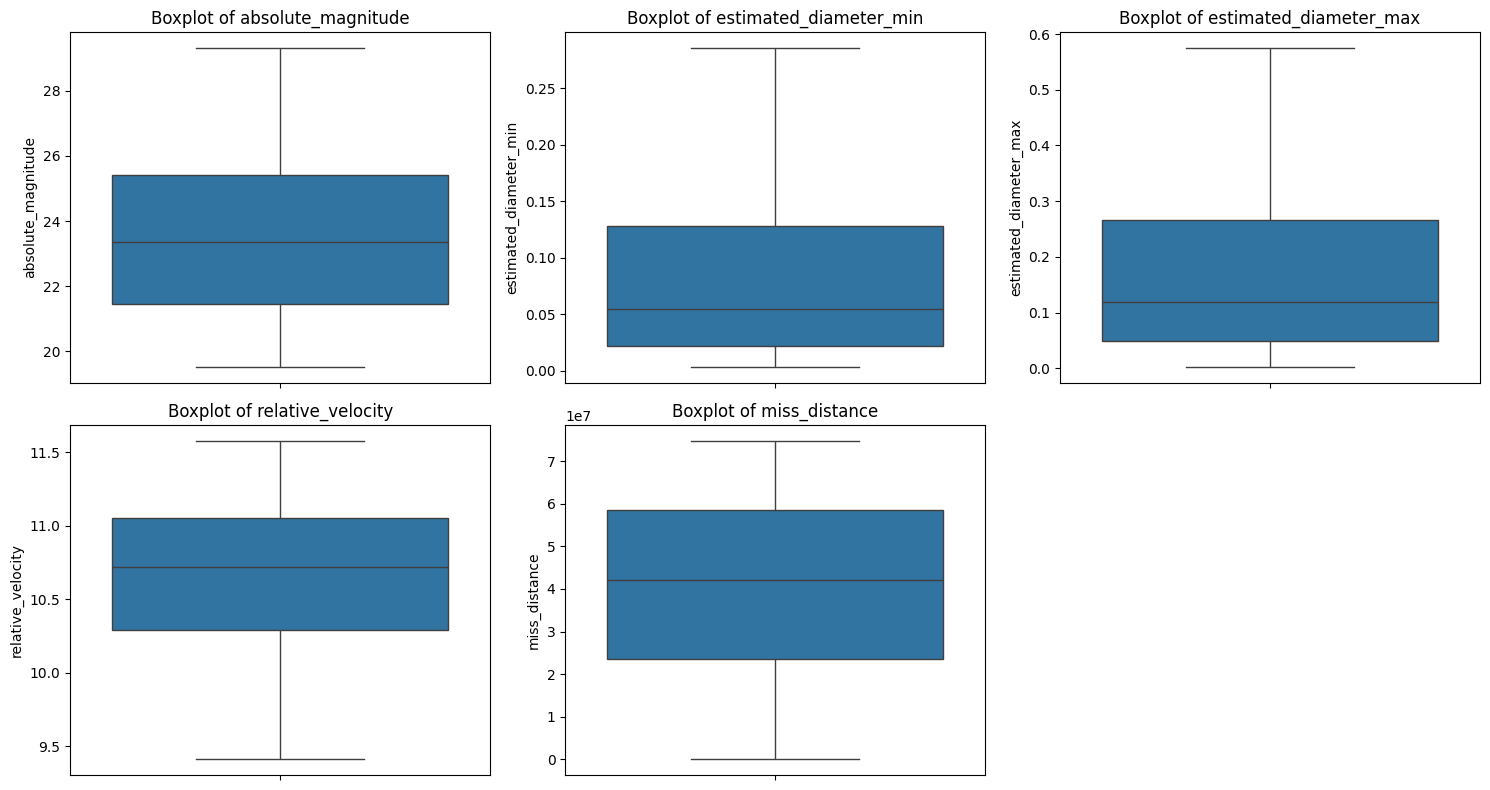

In [16]:
# Check for outliers in all numerical columns
numeric_columns = ['absolute_magnitude', 'estimated_diameter_min',
                   'estimated_diameter_max', 'relative_velocity', 'miss_distance']

plt.figure(figsize=(15, 8))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=data[column])
    plt.title(f"Boxplot of {column}")
plt.tight_layout()
plt.show()


In [17]:
# Get the number of rows and columns
num_rows, num_cols = data.shape

print(f"Number of data points (rows): {num_rows}")
print(f"Number of features (columns): {num_cols}")

Number of data points (rows): 295768
Number of features (columns): 9


In [18]:
# Check for missing values
print(data.isnull().sum())
# Drop rows with missing values
data.dropna(inplace=True)  # Drop rows with missing values
# Check for duplicates
print(data.duplicated().sum())

neo_id                    0
name                      0
absolute_magnitude        0
estimated_diameter_min    0
estimated_diameter_max    0
orbiting_body             0
relative_velocity         0
miss_distance             0
is_hazardous              0
dtype: int64
0


is_hazardous
False    263579
True      32189
Name: count, dtype: int64
is_hazardous
False    0.891168
True     0.108832
Name: proportion, dtype: float64


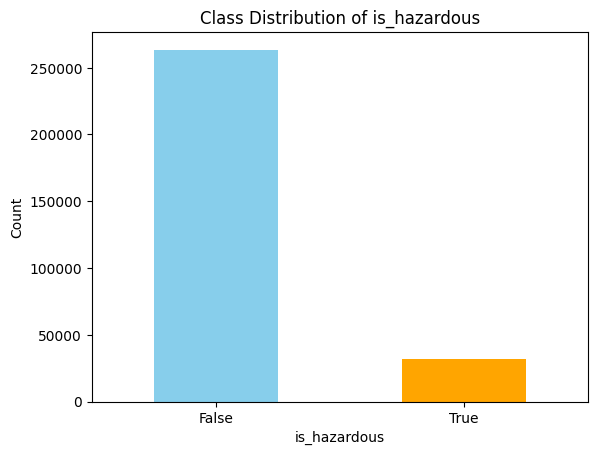

In [19]:
# Check the balance of the `is_hazardous` column
class_counts = data['is_hazardous'].value_counts()
print(class_counts)

# Calculate the proportions
class_proportions = data['is_hazardous'].value_counts(normalize=True)
print(class_proportions)

# Visualize the class distribution
import matplotlib.pyplot as plt

class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution of is_hazardous')
plt.xlabel('is_hazardous')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [20]:
# Drop the 'name' column
data = data.drop(columns=['name'], axis=1)
data = data.drop(columns=['neo_id'], axis=1)

# Encode the 'orbiting_body' column
label_encoder = LabelEncoder()
data['orbiting_body'] = label_encoder.fit_transform(data['orbiting_body'])

# Separate features (X) and target (y)
x = data.drop(columns=['is_hazardous'], axis=1)
y = data['is_hazardous']



In [21]:
# Apply SMOTE to make target balance
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

# Combine resampled data into a single DataFrame
resampled_df = pd.DataFrame(x_resampled, columns=x.columns)
resampled_df['is_hazardous'] = y_resampled

# Check the updated dataset
print("Original class distribution:", Counter(y))
print("Resampled class distribution:", Counter(y_resampled))
print("Updated dataset shape:", resampled_df.shape)



Original class distribution: Counter({False: 263579, True: 32189})
Resampled class distribution: Counter({False: 263579, True: 263579})
Updated dataset shape: (527158, 7)


is_hazardous
False    263579
True     263579
Name: count, dtype: int64
is_hazardous
False    0.5
True     0.5
Name: proportion, dtype: float64


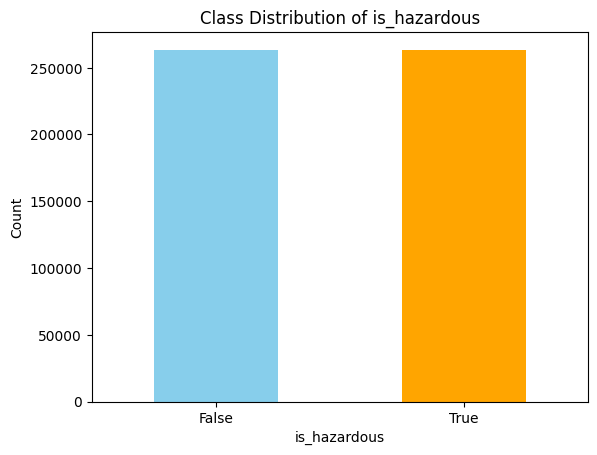

In [22]:
# Check the balance of the `is_hazardous` column
class_counts = resampled_df['is_hazardous'].value_counts()
print(class_counts)

# Calculate the proportions
class_proportions = resampled_df['is_hazardous'].value_counts(normalize=True)
print(class_proportions)

# Visualize the class distribution
import matplotlib.pyplot as plt

class_counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Class Distribution of is_hazardous')
plt.xlabel('is_hazardous')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


In [23]:
# update datasset
data=resampled_df
data

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,21.450000,0.127794,0.266063,0,10.121277,6.720689e+07,False
1,20.630000,0.181374,0.367882,0,11.275823,3.039644e+07,False
2,22.700000,0.073861,0.158209,0,10.933777,6.311863e+07,False
3,25.000000,0.026233,0.057735,0,10.768035,4.290521e+07,False
4,21.500000,0.125059,0.260731,0,10.965683,2.727908e+07,True
...,...,...,...,...,...,...,...
527153,21.613054,0.119562,0.249846,0,11.131268,3.655835e+07,True
527154,20.229372,0.214602,0.428633,0,11.051236,2.358362e+07,True
527155,20.576145,0.192734,0.386279,0,10.770687,4.172522e+07,True
527156,21.625387,0.120761,0.251619,0,10.430320,4.292339e+07,True



# Model Training

In [24]:
X = data.drop(columns=['is_hazardous'], axis=1)
Y = data['is_hazardous']

In [25]:
# Split into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}



In [27]:
# Dictionary to store results
results = {}

# Iterate through models and evaluate
for name, model in models.items():
    # Fit the model
    model.fit(X_train, Y_train)

    # Predictions for train and test sets
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    # Probabilities for AUC-ROC calculation (if supported)
    Y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    Y_test_proba= model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Accuracy
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)

    # Precision, Recall, and F1-Score
    train_precision = precision_score(Y_train, Y_train_pred)
    test_precision = precision_score(Y_test, Y_test_pred)

    train_recall = recall_score(Y_train, Y_train_pred)
    test_recall = recall_score(Y_test, Y_test_pred)

    train_f1 = f1_score(Y_train,Y_train_pred)
    test_f1 = f1_score(Y_test, Y_test_pred)

    # AUC-ROC
    train_auc = roc_auc_score(Y_train, Y_train_proba) if Y_train_proba is not None else None
    test_auc = roc_auc_score(Y_test, Y_test_proba) if Y_test_proba is not None else None

    # Store results
    results[name] = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Train Precision": train_precision,
        "Test Precision": test_precision,
        "Train Recall": train_recall,
        "Test Recall": test_recall,
        "Train F1-Score": train_f1,
        "Test F1-Score": test_f1,
        "Train AUC-ROC": train_auc,
        "Test AUC-ROC": test_auc
    }

# Print results
for model, metrics in results.items():
    print(f"{model}:")
    print(f"  Train Accuracy  = {metrics['Train Accuracy']:.4f}")
    print(f"  Test Accuracy   = {metrics['Test Accuracy']:.4f}")
    print(f"  Train Precision = {metrics['Train Precision']:.4f}")
    print(f"  Test Precision  = {metrics['Test Precision']:.4f}")
    print(f"  Train Recall    = {metrics['Train Recall']:.4f}")
    print(f"  Test Recall     = {metrics['Test Recall']:.4f}")
    print(f"  Train F1-Score  = {metrics['Train F1-Score']:.4f}")
    print(f"  Test F1-Score   = {metrics['Test F1-Score']:.4f}")
    print(f"  Train AUC-ROC   = {metrics['Train AUC-ROC']:.4f}" if metrics['Train AUC-ROC'] is not None else "  Train AUC-ROC   = N/A")
    print(f"  Test AUC-ROC    = {metrics['Test AUC-ROC']:.4f}" if metrics['Test AUC-ROC'] is not None else "  Test AUC-ROC    = N/A")
    print("-" * 50)


Decision Tree:
  Train Accuracy  = 1.0000
  Test Accuracy   = 0.9468
  Train Precision = 1.0000
  Test Precision  = 0.9474
  Train Recall    = 1.0000
  Test Recall     = 0.9463
  Train F1-Score  = 1.0000
  Test F1-Score   = 0.9468
  Train AUC-ROC   = 1.0000
  Test AUC-ROC    = 0.9468
--------------------------------------------------
Random Forest:
  Train Accuracy  = 1.0000
  Test Accuracy   = 0.9563
  Train Precision = 1.0000
  Test Precision  = 0.9557
  Train Recall    = 1.0000
  Test Recall     = 0.9571
  Train F1-Score  = 1.0000
  Test F1-Score   = 0.9564
  Train AUC-ROC   = 1.0000
  Test AUC-ROC    = 0.9931
--------------------------------------------------
Logistic Regression:
  Train Accuracy  = 0.8669
  Test Accuracy   = 0.8677
  Train Precision = 0.8038
  Test Precision  = 0.8049
  Train Recall    = 0.9707
  Test Recall     = 0.9711
  Train F1-Score  = 0.8794
  Test F1-Score   = 0.8802
  Train AUC-ROC   = 0.8923
  Test AUC-ROC    = 0.8915
-------------------------------------

The Decision Tree shows overfitting, with perfect training metrics but lower test accuracy and AUC-ROC. Random Forest also overfits slightly, though it generalizes well with high test accuracy and AUC-ROC. Logistic Regression performs consistently across train and test data without overfitting, but its accuracy and AUC-ROC are lower. Gradient Boosting offers the best balance, with train and test accuracies of  0.90 and AUC-ROC values of 0.92. It shows no overfitting and strong generalization, making it the most suitable model for predictions.

**Gradient Boosting is the best choice for prediction because:**
**It avoids overfitting, with train and test metrics closely aligned.**
**It has a high AUC-ROC score, indicating good predictive power**.

# Prediction

In [28]:
# Select best model (example: Gradient Boosting)
best_model = GradientBoostingClassifier(random_state=42)
best_model.fit(X_train, Y_train)


GradientBoostingClassifier(random_state=42)

In [35]:
# Example new data for prediction
new_data = pd.DataFrame({
    "absolute_magnitude": [25.700000],
    "estimated_diameter_min": [0.173861],
    "estimated_diameter_max": [0.258209],
    "orbiting_body": [0],
    "relative_velocity": [13.933777],
    "miss_distance": [6.511863e+07]
})

# Preprocess the new data
new_data_scaled = scaler.transform(new_data)

# Predict using the trained model
new_prediction = best_model.predict(new_data_scaled)
new_proba = best_model.predict_proba(new_data_scaled)

print(f"Predicted class: {new_prediction[0]}")  # 0 for non-hazardous, 1 for hazardous
print(f"Predicted probabilities: {new_proba[0]}")


Predicted class: True
Predicted probabilities: [0.09619713 0.90380287]
